In [1]:
import numpy as np
import torch as th
import qepsilon as qe
from qepsilon import *
from task import *
from matplotlib import pyplot as plt
import time
import json
## do not print the tensor in scientific notation
th.set_printoptions(sci_mode=False, precision=3)
dev = 'cpu'

## Define the one qubit system with initial state $|\downarrow\rangle$

In [2]:
batchsize = 512
qubit = qe.QubitLindbladSystem(n_qubits=1, batchsize=batchsize)
qubit.to(dev)
qubit.set_rho_by_config([0])

## Define noise terms in the time-dependent Hamiltonian

In [3]:
sz_shot = ShotbyShotNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_shot", batchsize=batchsize, amp=0.1, requires_grad=True).to(dev)
sz_shot.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz_shot)

sz0 = LangevinNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_color", batchsize=batchsize, tau=20, amp=0.01, requires_grad=True).to(dev)
sz0.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz0)

sz1 = PeriodicNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_60hz", batchsize=batchsize, tau=(1000/60 ), amp=0.01, requires_grad=True, requires_grad_amp_only=True).to(dev)
sz1.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz1)

sz2 = PeriodicNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_120hz", batchsize=batchsize, tau=(1000/120), amp=0.01, requires_grad=True, requires_grad_amp_only=True).to(dev)
sz2.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz2)

sz3 = PeriodicNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_180hz", batchsize=batchsize, tau=(1000/180), amp=0.01, requires_grad=True, requires_grad_amp_only=True).to(dev)
sz3.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz3)

sz4 = PeriodicNoisePauliOperatorGroup(n_qubits=1, id="sz_noise_240hz", batchsize=batchsize, tau=(1000/240), amp=0.01, requires_grad=True, requires_grad_amp_only=True).to(dev)
sz4.add_operator('Z')
qubit.add_operator_group_to_hamiltonian(sz4)

## Define the time-indepedent Jump operators in the Lindblad equation

In [4]:
sx_jump = StaticPauliOperatorGroup(n_qubits=1, id="sx_jump", batchsize=batchsize, coef=np.sqrt(0.0001), static=False,requires_grad=True).to(dev)
sx_jump.add_operator('X')
qubit.add_operator_group_to_jumping(sx_jump)

sz_jump = StaticPauliOperatorGroup(n_qubits=1, id="sz_jump", batchsize=batchsize, coef=np.sqrt(0.0001), static=False, requires_grad=True).to(dev)
sz_jump.add_operator('Z')
qubit.add_operator_group_to_jumping(sz_jump)

## Define the error channel associated with each control pulse $R_{\vec{n}}(\theta)$

In [5]:
depol_channel = DepolarizationChannel(n_qubits=1, id="depol_channel", batchsize=batchsize, p=0.002, requires_grad=True).to(dev)
qubit.add_operator_group_to_channel(depol_channel)

## Load one-molecule experimental data from [Science 382.6675 (2023): 1143-1147.]

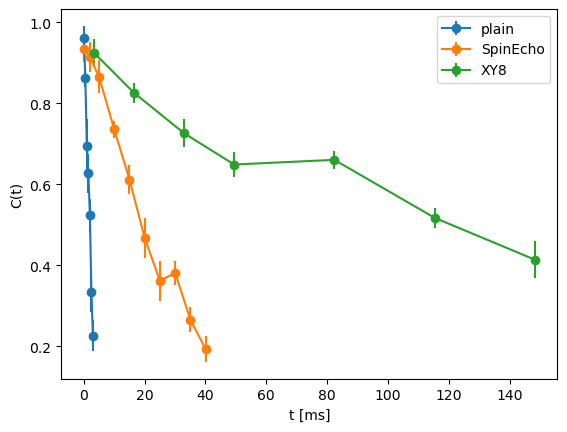

In [6]:
preparation_rate = 0.824
XY8_cycle_time = 1.6  #ms

## load csv data and correct by preparation rate
data_plain = np.loadtxt('./Data/Fig3C_GreenTriangles.csv', delimiter=',', skiprows=1)
data_plain = th.tensor(data_plain, dtype=th.float).to(dev)
data_plain[:, 1] /= preparation_rate

data_echo = np.loadtxt('./Data/Fig3C_RedSquares.csv', delimiter=',', skiprows=1)
data_echo = th.tensor(data_echo, dtype=th.float).to(dev)
data_echo[:, 1] /= preparation_rate


data_XY8 = np.loadtxt('./Data/Fig3C_BlueCircles.csv', delimiter=',', skiprows=1)
data_XY8 = th.tensor(data_XY8, dtype=th.float).to(dev)
data_XY8[:, 1] /= preparation_rate

plt.errorbar(data_plain[:,0], data_plain[:,1], data_plain[:,2], markersize=6, marker='o', label='plain')
plt.errorbar(data_echo[:,0], data_echo[:,1], data_echo[:,2],markersize=6, marker='o', label='SpinEcho')
plt.errorbar(data_XY8[:,0], data_XY8[:,1], data_XY8[:,2], markersize=6, marker='o', label='XY8')
plt.xlabel('t [ms]')
plt.ylabel('C(t)/')
plt.legend()
plt.show()
plt.close()


## Train DIQCD model 

In [7]:
## Load the three control schemes
from task import RamseyScan, RamseySpinEcho, RamseyXY8

## training parameters
nepoch = 200
optimizer = th.optim.Adam([{'params': qubit.HamiltonianParameters(), 'lr': 0.1},
                          {'params': qubit.JumpingParameters(), 'lr': 0.001},
                          {'params': qubit.ChannelParameters(), 'lr': 0.1}])

In [8]:
loss_list = []
paras_list = []
for epoch in range(nepoch):
    loss = 0
    ## Ramsey experiment without echo
    Ramsey_Plain_P0 = RamseyScan(qubit, dt=0.01, T=3, theta_list=[0, np.pi], observe_at=data_plain[:, 0])
    Ramsey_Plain_Contrast = th.abs(Ramsey_Plain_P0[:, 1] - Ramsey_Plain_P0[:, 0])
    loss += ((Ramsey_Plain_Contrast - data_plain[:, 1]) ** 2).mean()

    ## Ramsey experiment with echo
    Ramsey_Echo_Contrast = []
    for T in data_echo[:, 0]:
        Ramsey_Echo_P0 = RamseySpinEcho(qubit, dt=0.05, T=T, theta_list=[0, np.pi])
        Ramsey_Echo_Contrast.append(th.abs(Ramsey_Echo_P0[1] - Ramsey_Echo_P0[0]))
    Ramsey_Echo_Contrast = th.stack(Ramsey_Echo_Contrast)
    loss += ((Ramsey_Echo_Contrast - data_echo[:, 1]) ** 2).mean()

    ## Ramsey experiment with XY8 sequence
    Ramsey_XY8_P0 = RamseyScan_XY8(qubit, dt=0.1, T=150, cycle_time=XY8_cycle_time, theta_list=[0, np.pi], observe_at=data_XY8[:, 0])
    Ramsey_XY8_Contrast = th.abs(Ramsey_XY8_P0[:, 1] - Ramsey_XY8_P0[:, 0])
    loss += ((Ramsey_XY8_Contrast - data_XY8[:, 1]) ** 2).mean()
    
    ## step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.detach().cpu().numpy())
    
    # Save parameter trajectories
    paras = {}
    all_opg_list = qubit.hamiltonian_operator_groups + qubit.jumping_operator_groups + [depol_channel]
    for opg in all_opg_list:
        paras[opg.id] = {}
        para = [x for x in opg.named_parameters()]
        for _p in para:
            paras[opg.id][_p[0]] = _p[1].item()
    paras_list.append(paras)
    
    ## report
    if epoch % 10 == 0:
        print(f"================= Epoch={epoch}/{nepoch}, Loss={loss_list[-1]} =================")
        # for op in qubit.hamiltonian_operator_groups:
        #     if op.tau is not None:
        #         print(f'Hamiltonian: {op.id} Tau={op.tau.mean()}ms, Amp={op.amp.mean()}')
        #     else:
        #         print(f'Hamiltonian: {op.id} Amp={op.amp.mean()}')
        # for op in qubit.jumping_operator_groups:
        #     print(f'Jump: {op.id} Amp={op.coef.mean()}')
        # print(f"depol_channel: p={depol_channel.p.mean()}")
        print(f"Ramsey Plain Data={data_plain[:, 1]}")
        print(f"Ramsey Plain Simulated={Ramsey_Plain_Contrast.detach()}")
        print(f"Ramsey Echo Data={data_echo[:, 1]}")
        print(f"Ramsey Echo Simulated={Ramsey_Echo_Contrast.detach()}")
        print(f"Ramsey XY8 Data={data_XY8[:, 1]}")
        print(f"Ramsey XY8 Simulated={Ramsey_XY8_Contrast.detach()}")
        th.save(qubit.state_dict(), "state_dict.pt")
        


================= Epoch=0/200, Loss=0.4118886888027191 =================
Ramsey Plain Data=tensor([0.962, 0.862, 0.695, 0.627, 0.523, 0.334, 0.226])
Ramsey Plain Simulated=tensor([1.000, 0.994, 0.979, 0.953, 0.919, 0.876, 0.828])
Ramsey Echo Data=tensor([0.934, 0.915, 0.865, 0.735, 0.611, 0.467, 0.361, 0.382, 0.266, 0.194])
Ramsey Echo Simulated=tensor([1.000, 0.999, 0.994, 0.987, 0.979, 0.973, 0.971, 0.965, 0.949, 0.928])
Ramsey XY8 Data=tensor([0.925, 0.826, 0.726, 0.649, 0.660, 0.517, 0.414])
Ramsey XY8 Simulated=tensor([0.957, 0.802, 0.630, 0.505, 0.318, 0.205, 0.129])
================= Epoch=10/200, Loss=0.10010824352502823 =================
Ramsey Plain Data=tensor([0.962, 0.862, 0.695, 0.627, 0.523, 0.334, 0.226])
Ramsey Plain Simulated=tensor([0.999, 0.964, 0.868, 0.731, 0.575, 0.422, 0.288])
Ramsey Echo Data=tensor([0.934, 0.915, 0.865, 0.735, 0.611, 0.467, 0.361, 0.382, 0.266, 0.194])
Ramsey Echo Simulated=tensor([1.000, 0.994, 0.961, 0.909, 0.841, 0.819, 0.801, 0.716, 0.675,

### Plot agreement between data and final model. Plot loss function

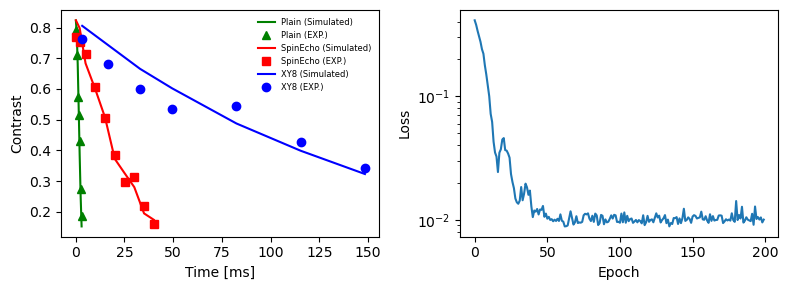

In [9]:
fig, axs = plt.subplots(1,2, figsize=(8, 3))
ax, ax1 = axs
ax.plot(data_plain[:, 0], Ramsey_Plain_Contrast.detach().numpy() * preparation_rate, label='Plain (Simulated)', color='green')
ax.plot(data_plain[:, 0], data_plain[:, 1] * preparation_rate, marker='^', color='green', label='Plain (EXP.)', linestyle='None') # triangle marker
ax.plot(data_echo[:, 0], Ramsey_Echo_Contrast.detach().numpy() * preparation_rate, label='SpinEcho (Simulated)', color='red')
ax.plot(data_echo[:, 0], data_echo[:, 1] * preparation_rate, marker='s', color='red', label='SpinEcho (EXP.)', linestyle='None') # square marker
ax.plot(data_XY8[:, 0], Ramsey_XY8_Contrast.detach().numpy() * preparation_rate, label='XY8 (Simulated)', color='blue')
ax.plot(data_XY8[:, 0], data_XY8[:, 1] * preparation_rate, marker='o', color='blue', label='XY8 (EXP.)', linestyle='None') # circle marker
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Contrast')
ax.legend(fontsize=6, frameon=False)

ax1.semilogy(loss_list)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
# ax.legend()
plt.tight_layout()
plt.show()
plt.close()

### plot the evolvement of all parameters 

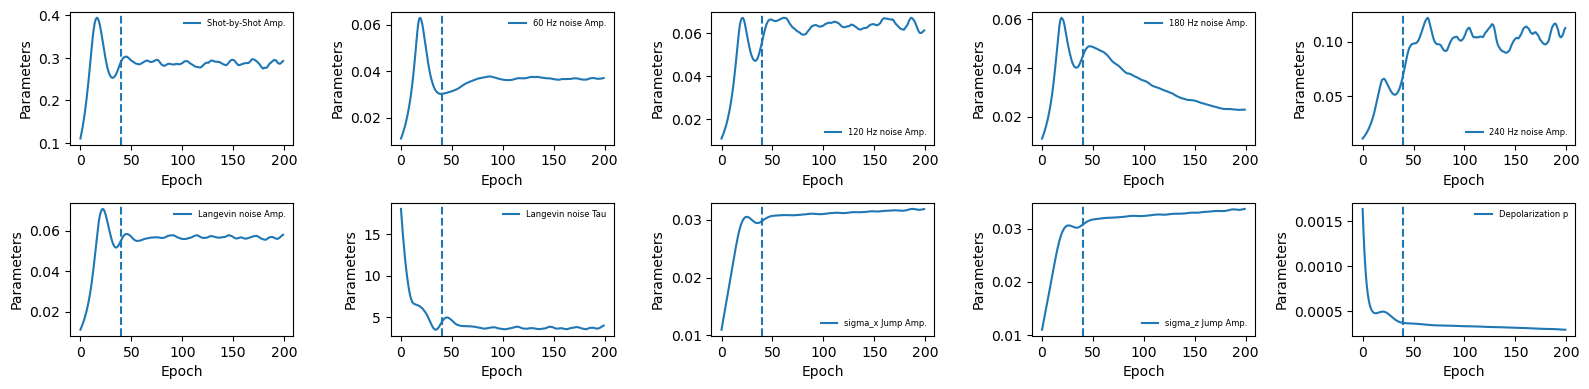

In [10]:

sz_noise_shot_amp = np.exp(np.array([p['sz_noise_shot']['logamp'] for p in paras_list]))
sz_noise_langevin_amp = np.exp(np.array([p['sz_noise_color']['logamp'] for p in paras_list]))
sz_noise_langevin_tau = np.exp(np.array([p['sz_noise_color']['logtau'] for p in paras_list]))

sz_noise_60hz_amp = np.exp(np.array([p['sz_noise_60hz']['logamp'] for p in paras_list]))
sz_noise_120hz_amp = np.exp(np.array([p['sz_noise_120hz']['logamp'] for p in paras_list]))
sz_noise_180hz_amp = np.exp(np.array([p['sz_noise_180hz']['logamp'] for p in paras_list]))
sz_noise_240hz_amp = np.exp(np.array([p['sz_noise_240hz']['logamp'] for p in paras_list]))
sx_jump_coef = np.array([p['sx_jump']['coef'] for p in paras_list])
sz_jump_coef = np.array([p['sz_jump']['coef'] for p in paras_list])
depol_p = np.array([p['depol_channel']['_p'] for p in paras_list])
depol_p =(np.tanh(depol_p)+1)/2.0
fig, axs = plt.subplots(2,5, figsize=(16, 4))
axs = axs.flatten()
axs[0].plot(sz_noise_shot_amp, label='Shot-by-Shot Amp.')
axs[1].plot(sz_noise_60hz_amp, label='60 Hz noise Amp.')
axs[2].plot(sz_noise_120hz_amp, label='120 Hz noise Amp.')
axs[3].plot(sz_noise_180hz_amp, label='180 Hz noise Amp.')
axs[4].plot(sz_noise_240hz_amp, label='240 Hz noise Amp.')
axs[5].plot(sz_noise_langevin_amp, label='Langevin noise Amp.')
axs[6].plot(sz_noise_langevin_tau, label='Langevin noise Tau')

axs[7].plot(sx_jump_coef, label='sigma_x Jump Amp.')
axs[8].plot(sz_jump_coef, label='sigma_z Jump Amp.')
axs[9].plot(depol_p, label='Depolarization p')
for ax in axs: 
    ax.axvline(40, linestyle='dashed')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Parameters')
    ax.legend(fontsize=6, frameon=False)
plt.tight_layout()
plt.show()
plt.close()